In [34]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from pprint import pprint

In [28]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, date

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [12]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

start_date = '2016-09-01'
end_date = '2016-09-15'

start_dt = (dt.datetime.strptime(start_date, "%Y-%m-%d")).date()
end_dt = (dt.datetime.strptime(end_date, "%Y-%m-%d")).date()

#one year ago dates
start_oneyearago = start_dt - dt.timedelta(days=365)
end_oneyearago = end_dt - dt.timedelta(days=365)

# --- call the calc_temps function with the previous year dates calculated above ---
temps = calc_temps(start_oneyearago, end_oneyearago)
tmin = temps[0][0]
tavg = round(temps[0][1], 2)
tmax = temps[0][2]
print(f"Selected start date: {start_date} | Selected end date: {end_date}")
print(f"Temperatures  one year ago from {start_oneyearago} to {end_oneyearago}:")
print(f"Minimum temp: {tmin} | Average temp: {tavg} | Max temp: {tmax}")

Selected start date: 2016-09-01 | Selected end date: 2016-09-15
Temperatures  one year ago from 2015-09-02 to 2015-09-16:
Minimum temp: 73.0 | Average temp: 78.47 | Max temp: 85.0


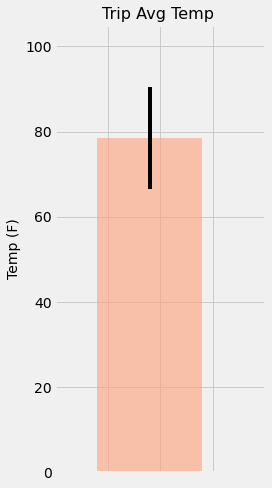

In [14]:
# Plot the results from your previous query as a bar chart. 

yerr = tmax - tmin
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize = (4,7))
plt.bar(1.5, height=tavg, yerr=yerr, width = 2, color='lightsalmon', alpha = 0.60,  align='center')
xaxis_values = np.arange(-0.3,3.8, step=1)
plt.title("Trip Avg Temp ", fontsize = 16)
plt.ylabel("Temp (F)", fontsize=14)
plt.ylim(0,105)
plt.xticks(xaxis_values, "")

plt.tight_layout()
plt.savefig("AvgTemp.png")
plt.show()

### Daily Rainfall Average

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

prcp_df = pd.DataFrame(session.query(measurement.date, measurement.station, measurement.prcp).\
                               filter((measurement.date >= start_oneyearago) & \
                               (measurement.date <= end_oneyearago)).all(),columns=["date", "station","precipitation"])

#removing null
prcp_df.dropna(axis=0, how="any", inplace=True)
#group by station and get total precipitation amount for each station
total_prcp = pd.DataFrame(prcp_df.groupby('station').sum())

station_df = pd.DataFrame(session.query(station.station, station.name, station.latitude, station.longitude,\
                                        station.elevation).all(),columns=["station", "name","latitude","longitude","elevation"])

rainfall_df = pd.merge(total_prcp, station_df, on="station")
rainfall_df.sort_values('precipitation', ascending=False, inplace=True)
rainfall_df.reset_index(inplace=True, drop=True)

rainfall_df.head()

,station,precipitation,name,latitude,longitude,elevation
0,USC00516128,17.54,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,9.75,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,6.99,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,6.84,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00519397,3.32,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [26]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

trip_startdate = dt.date(2017,8,1)
trip_enddate = dt.date(2017,8,7)

date_range = pd.date_range(trip_startdate, trip_enddate)

# Stip off the year and save a list of %m-%d strings
date_list = [d.strftime("%m-%d") for d in date_range]

# Loop through the list of %m-%d strings and calculate the normals for each date
normal = [daily_normals(d)[0] for d in date_list]
pprint(normal)

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]


In [37]:
normal_df = pd.DataFrame(
    daily_normal, columns=["tmin", "tavg", "tmax"], index=date_range
)
normal_df.index.name = "Date"
normal_df.head()

,tmin,tavg,tmax
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0


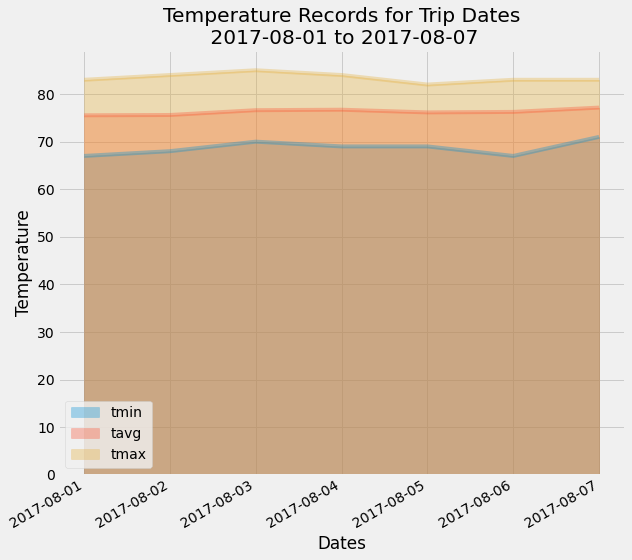

In [40]:
# Plot the daily normals as an area plot with `stacked=False`

normal_df.plot(kind="area", stacked=False, x_compat=True, alpha=0.333, figsize=(9, 8))
plt.title(f"Temperature Records for Trip Dates\n {trip_startdate} to {trip_enddate}")
plt.xlabel("Dates")
plt.ylabel("Temperature")


plt.tight_layout()
plt.savefig("dailynormals.png")
plt.show()

## Close Session

In [41]:
session.close()